# Assignment 3

## Part A : Gaussian Model

### A.0 Imports

In [121]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import numpy as np
from numpy.linalg import det, inv

import matplotlib.pyplot as plt
import seaborn as sns

### A.1 Data Loading

In [122]:
def data_loading(data_set):
    x=data_set.data #this is already flattened
    y=data_set.target
    x_train, x_temp, y_train, y_temp = train_test_split(
        x,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp,
        y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    scale = StandardScaler()
    x_train_standard = scale.fit_transform(x_train)
    x_val_standard   = scale.transform(x_val)
    x_test_standard  = scale.transform(x_test)

    return x_train_standard,x_val_standard,x_test_standard,y_train,y_val,y_test

### A.2 Training and Prediction Functions

In [ ]:

class Gaussian_model:
    def __init__(self, lambda_reg=0.01):
        self.lambda_reg = lambda_reg
        self.class_priors = None
        self.class_means = None
        self.shared_cov = None

    def set_lambda(self, lam:float):
        self.lambda_reg = lam

    def train(self, x, y):
        x=np.array(x)
        y=np.array(y)
        _, counts = np.unique(y, return_counts=True)
        total_count = len(y)
        p_k = []
        p_k= counts / total_count #prior probability of each class
        self.class_priors = p_k

        n_samples, n_features = x.shape
        M_k = np.zeros((10, n_features))
        for class_label in range(10):
            class_indices = np.where(y == class_label)[0]
            class_images = x[class_indices]
            mean_image = np.mean(class_images, axis=0)
            M_k[class_label] = mean_image

        self.class_means=M_k


        cov_sum = np.zeros((n_features,n_features))
        for i in range(n_samples):
            mu_k = self.class_means[y[i]]
            diff = x[i] - mu_k
            cov_sum += np.outer(diff, diff)   # diff * diff T

        shared_cov = cov_sum / n_samples
        shared_cov += self.lambda_reg * np.eye(n_features) # regularization
        self.shared_cov=shared_cov
        
    #def log_gaussian_pdf(self,x, mu,Sigma_inv,logdet): #computes exact probability
    #    D = x.shape[0]
    #    det_term = -0.5 * logdet # det function
    #    x_minus_mu = x - mu
    #    quad_term = np.dot(np.dot(x_minus_mu, Sigma_inv), x_minus_mu)
    #    quad_term_scaled = -0.5 * quad_term
    #    const_term = -D / 2.0 * np.log(2 * np.pi)
    #    log_likelihood = const_term + det_term + quad_term_scaled
    #    return log_likelihood

    def predict(self,x):
        predictions = np.zeros(len(x), dtype=int)
        Sigma_inv = inv(self.shared_cov)
        #sign, logdetcov = np.linalg.slogdet(self.shared_cov)
        for i in range(len(x)):
            max_log_score=-np.inf
            for k in range(10):
                #log_likelihood = self.log_gaussian_pdf(x[i], self.class_means[k],Sigma_inv,logdetcov)
                log_likelihood = np.dot(np.dot(x[i] - self.class_means[k], Sigma_inv), x[i] - self.class_means[k]) * -0.5
                log_prior = np.log(self.class_priors[k])
                log_score = log_likelihood + log_prior
                if log_score > max_log_score:
                    max_log_score = log_score
                    predictions[i]= k

        return predictions


    def score(self,x,y):
        predictions = self.predict(x)
        return np.mean(predictions == y)


    def test(self,x,y):
        predictions = self.predict(x)
        test_accuracy = self.score(x,y)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y, predictions, average='macro', zero_division=0
        )
        cm = confusion_matrix(y, predictions) 
        metrics = {
            'test_accuracy': test_accuracy,
            'macro_precision': precision,
            'macro_recall': recall,
            'macro_f1': f1,
            'confusion_matrix': cm
        }

        return metrics, predictions

### A.3.1 Hyparparameter Tuning

In [124]:
def hyperparameter_tuning(lambda_values,x_train,y_train,x_val,y_val):
    results = {}
    best_lambda = None
    best_accuracy = 0
    for lamda in lambda_values:
        model = Gaussian_model(lamda)
        model.train(x_train,y_train)
        acc=model.score(x_val,y_val)
        results[lamda]=acc
        if acc > best_accuracy:
            best_accuracy = acc
            best_lambda = lamda
            best_model = model

    return best_model,results,best_lambda

### A.3.2 Evaluation and Comparision

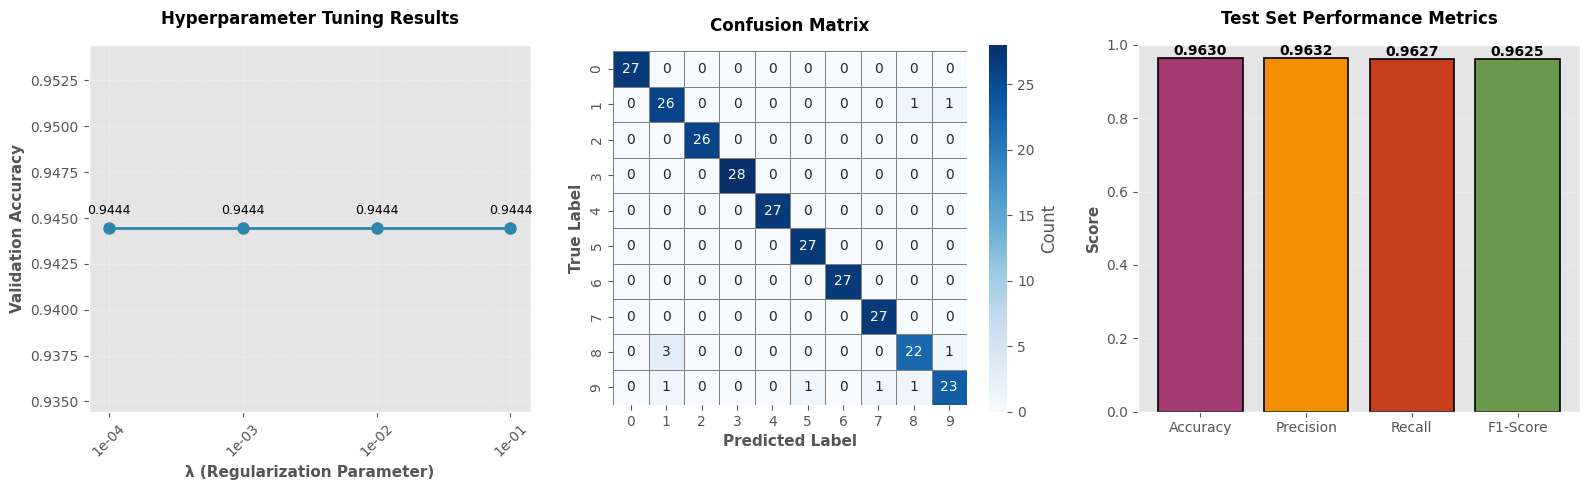

In [125]:
def print_results(metrics, accuracies,lambdas):
    accuracies = [accuracies[lam] for lam in lambdas]
    fig = plt.figure(figsize=(16, 5))
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(range(len(lambdas)), accuracies, 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax1.set_xticks(range(len(lambdas)))
    ax1.set_xticklabels([f'{l:.0e}' for l in lambdas], rotation=45)
    ax1.set_xlabel('λ (Regularization Parameter)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Hyperparameter Tuning Results', fontsize=12, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])

    for i, (l, acc) in enumerate(zip(lambdas, accuracies)):
        ax1.annotate(f'{acc:.4f}', (i, acc), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=9)

    ax2 = plt.subplot(1, 3, 2)
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
                cbar_kws={'label': 'Count'}, ax=ax2, linewidths=0.5, linecolor='gray')
    ax2.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax2.set_title('Confusion Matrix', fontsize=12, fontweight='bold', pad=15)

    ax3 = plt.subplot(1, 3, 3)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [
        metrics['test_accuracy'],
        metrics['macro_precision'],
        metrics['macro_recall'],
        metrics['macro_f1']
    ]

    colors = ['#A23B72', '#F18F01', '#C73E1D', '#6A994E']
    bars = ax3.bar(metric_names, metric_values, color=colors, edgecolor='black', linewidth=1.2)
    ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax3.set_title('Test Set Performance Metrics', fontsize=12, fontweight='bold', pad=15)
    ax3.set_ylim([0, 1.0])
    ax3.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{value:.4f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    x_train,x_val,x_test,y_train,y_val,y_test=data_loading(sk.datasets.load_digits())
    model=Gaussian_model()
    lambda_values=[1e-4, 1e-3, 1e-2, 1e-1]
    model,validations,lamba=hyperparameter_tuning(lambda_values,x_train,y_train,x_val,y_val)
    x_train_combined = np.concatenate((x_train, x_val), axis=0)
    y_train_combined = np.concatenate((y_train, y_val), axis=0)
    model.set_lambda(lamba)
    model.train(x_train_combined,y_train_combined)
    metrics, preds =model.test(x_test,y_test)
    print_results(metrics,validations,lambda_values)

### A.4 Report

-Prior Probability π_k: We assume the prior probability of observing any class follows a Multinomial distribution. 

-Class-Conditional Density p(x|y=k): We assume the features x for a given class k follow a Multivariate Gaussian Distribution (Normal Distribution) and we assume that all classes share the same covariance matrix Σ (Σ_λ after regularization)

-The model's parameters are estimated using Maximum Likelihood Estimation (MLE) from the training data:
    
    -Class Prior π_k: This is estimated as the fraction of training samples belonging to class k where π_k=(Number of samples in class k)/(Total number of samples)

    -Class Mean μ_k: This is the sample mean of the feature vectors for all samples belonging to class k where μ_k = 1/{N_k} *  sum(X_i)

    -Covariance Σ: This is a weighted average of the class-specific covariance matrices, calculated by summing the outer products of the centered feature vectors across all classes and dividing by the total number of samples

    -Regularized Covarience Σ_λ : The need for regularization is because the digits dataset is high-dimensional (64 features) and in high-dimensional spaces the estimated covariance matrix Σ can be singular or ill-conditioned (non-invertible or numerically unstable) This happens because the model has insufficient data relative to the number of parameters to estimate a full, stable covariance matrix the regularization formula Σ_λ = Σ + λ I (where  I  is the identity matrix) adds a small positive constant λ to the main diagonal of Σ this process is called shrinking and ensures the resulting matrix is invertible and numerically stable
    
-The choice of the regularization parameter would normally affect the model's stability however λ has a large optimal range where performance remains constant at 94.44% However, increasing or decreasing λ outside its optimal range would normally cause a sharp performance drop

-The single most frequent misclassification is when the true digit 8 is predicted as 1, occurring 3 times, in general, the digits 8 and 9 appear to be the most problematic true labels as they account for the highest total number of misclassifications:
   
    - 8 was misclassified 4 times in total.
    - 9 was misclassified 4 times in total.

The model also frequently confused digits with single vertical strokes (like 1 and 9) or digits prone to closure ambiguity (like 8 and 9).

-The primary strength of this Gaussianmodel is its strong performance, achieving nearly 96.3% accuracy with a simple, closed-form solution. The model is computationally efficient because it calculates the covariance matrix only once but its performance relies on the data approximately satisfying the Gaussian and shared covariance assumptions, which the pre-processed digits data seems to do reasonably well

-A key weakness is the reliance on the shared covariance assumption real-world digits often have different variances and so averaging this variance potentially hinders the separation of classes where the true variance structure is critical



# Part B:

### Naïve Bayes on Adult Income Dataset 
This notebook includes all required components:
- Data loading & preprocessing
- Basic distributions & feature-vs-class plots
- Manual Naïve Bayes implementation
- α smoothing analysis
- Feature subset experiments
- Probability distribution analysis
- sklearn comparison
- Confusion matrix
- Independence assumption discussion


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import CategoricalNB
np.random.seed(42)
plt.style.use('ggplot')  
sns.set_palette("deep")


## 1. Load Dataset

In [127]:
adult = fetch_openml('adult', version=2, as_frame=True)
df = adult.frame.copy()
df = df.astype(str)
df = df.replace('?', '<MISSING>').fillna('<MISSING>')
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,nan,103497,Some-college,10,Never-married,nan,Own-child,White,Female,0,0,30,United-States,<=50K


## 2. Keep Categorical Features Only

In [128]:
categorical_cols = [
    'workclass','education','marital-status','occupation',
    'relationship','race','sex','native-country'
]
df = df[categorical_cols + ['class']]
df.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K
4,nan,Some-college,Never-married,nan,Own-child,White,Female,United-States,<=50K


## 3. Basic Distributions

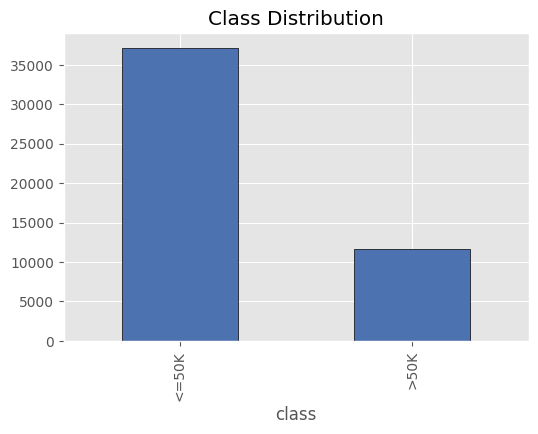

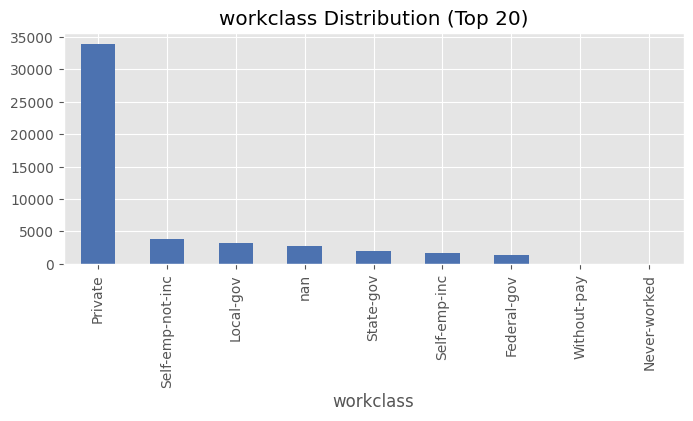

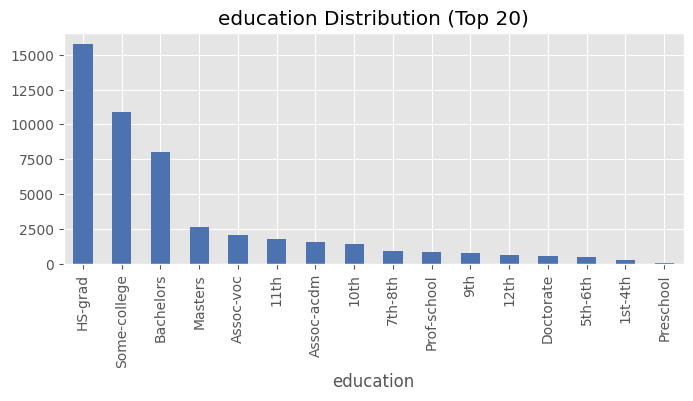

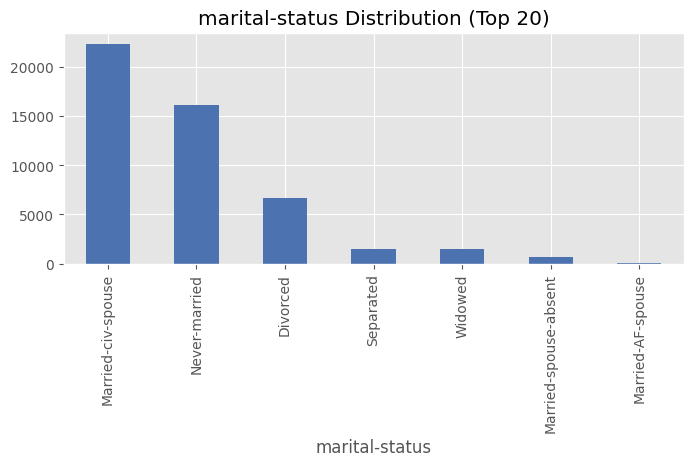

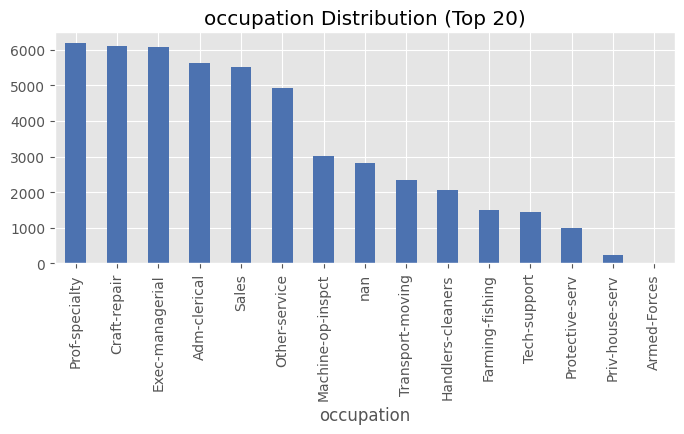

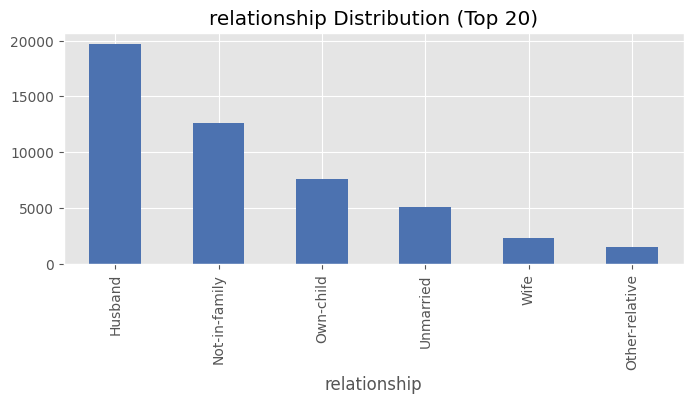

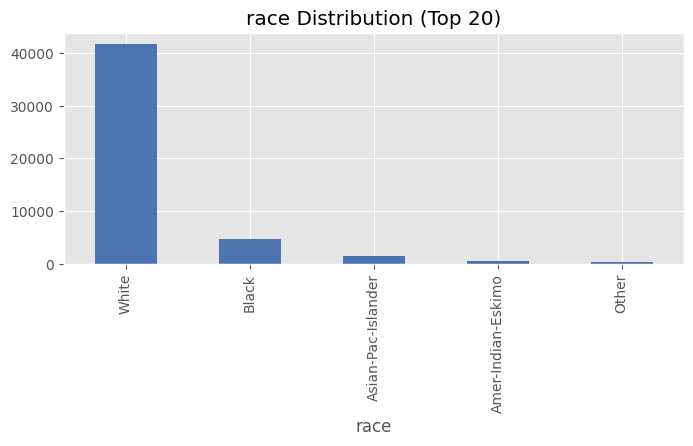

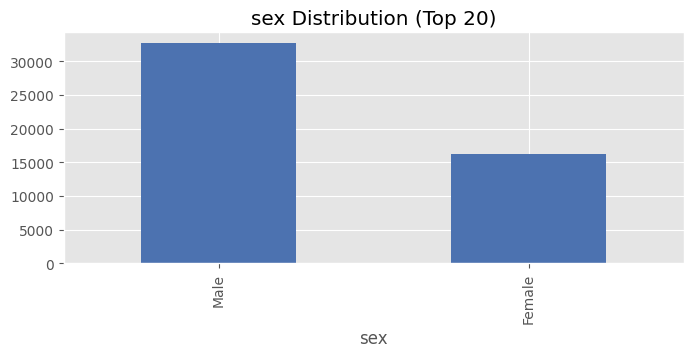

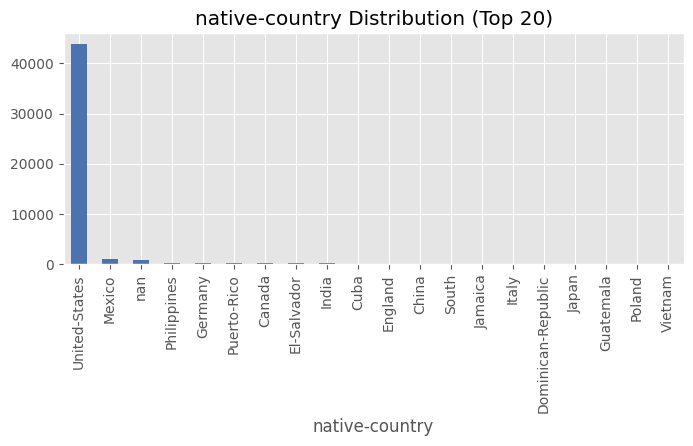

In [129]:
plt.figure(figsize=(6,4))
df['class'].value_counts().plot(kind='bar', edgecolor='k')
plt.title('Class Distribution')
plt.show()
for col in categorical_cols:
    plt.figure(figsize=(8,3))
    df[col].value_counts().iloc[:20].plot(kind='bar')
    plt.title(f'{col} Distribution (Top 20)')
    plt.show()

## 4. Feature vs Class — Stacked Bar Charts

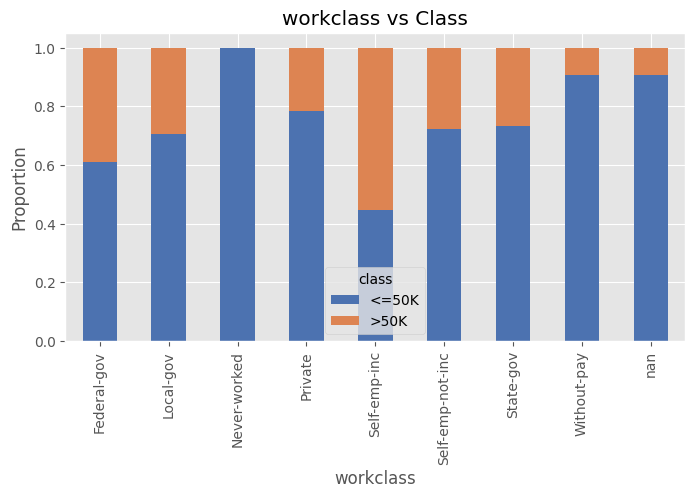

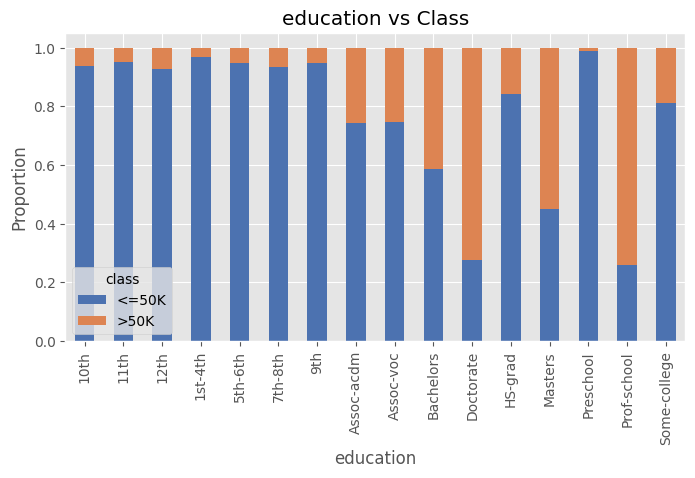

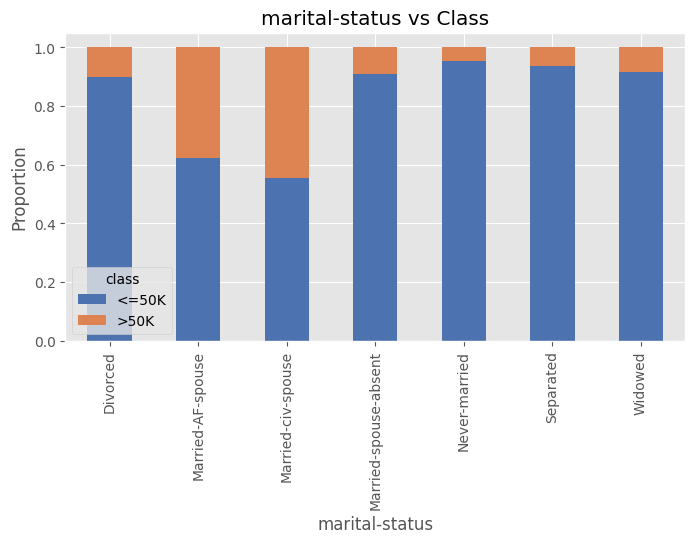

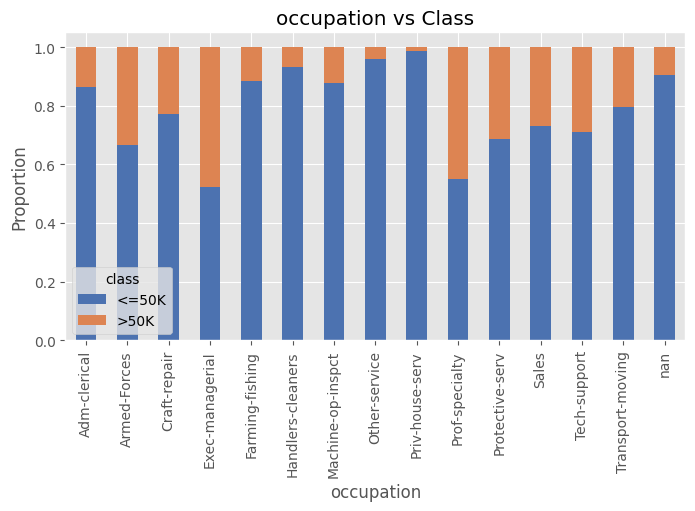

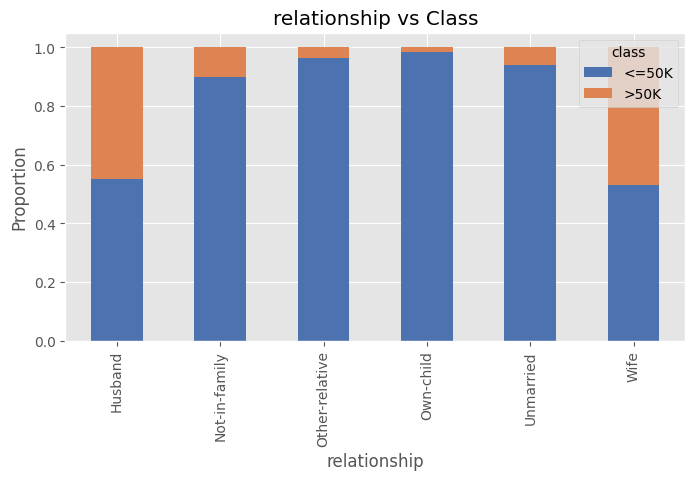

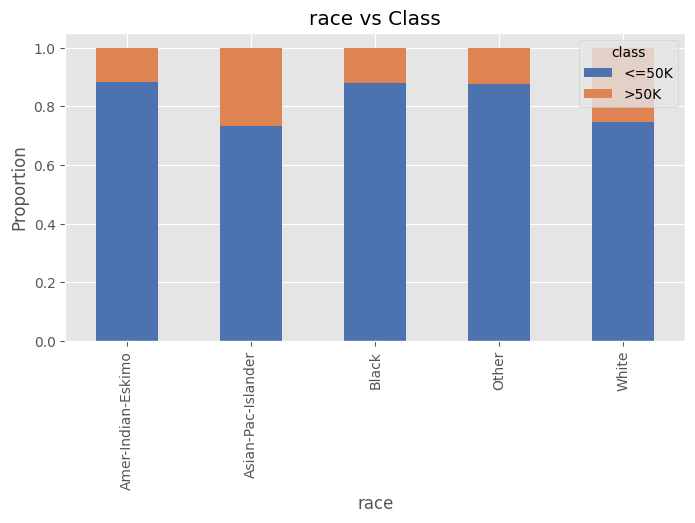

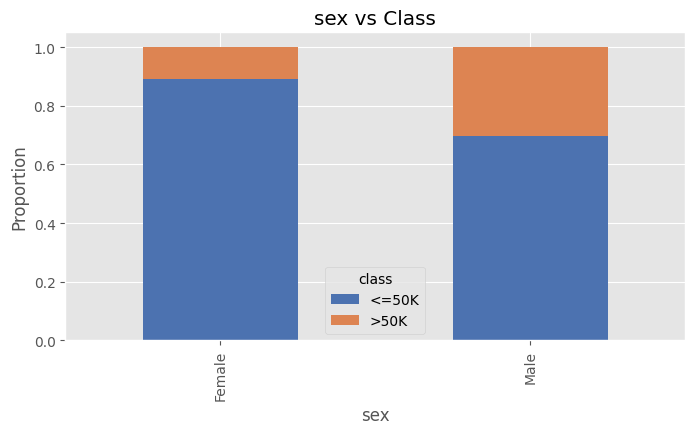

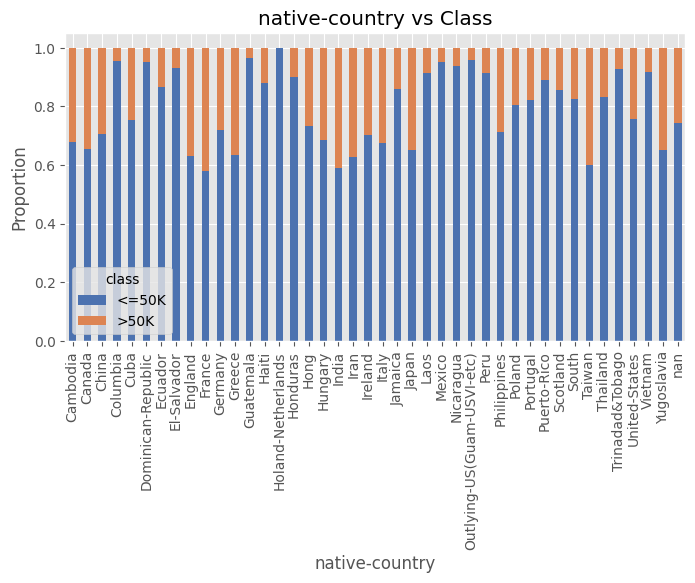

In [130]:
for col in categorical_cols:
    ct = pd.crosstab(df[col], df['class'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f'{col} vs Class')
    plt.ylabel('Proportion')
    plt.show()

## 5. Encode Categorical Features

In [131]:
encoders={}
df_encoded=df.copy()
for col in df.columns:
    df_encoded[col], enc = pd.factorize(df_encoded[col])
    encoders[col]=enc
df_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,0,0
2,1,2,1,2,1,1,0,0,1
3,0,3,1,0,1,0,0,0,1
4,2,3,0,3,0,1,1,0,0


## 6. Train / Validation / Test Split

In [132]:
train, temp = train_test_split(df_encoded, test_size=0.30, stratify=df_encoded['class'], random_state=42)
val, test = train_test_split(temp, test_size=0.50, stratify=temp['class'], random_state=42)
X_train=train.drop('class',axis=1).values
y_train=train['class'].values
X_val=val.drop('class',axis=1).values
y_val=val['class'].values
X_test=test.drop('class',axis=1).values
y_test=test['class'].values
len(X_train), len(X_val), len(X_test)

(34189, 7326, 7327)

## **Class Distribution Check After Train / Validation / Test Split**


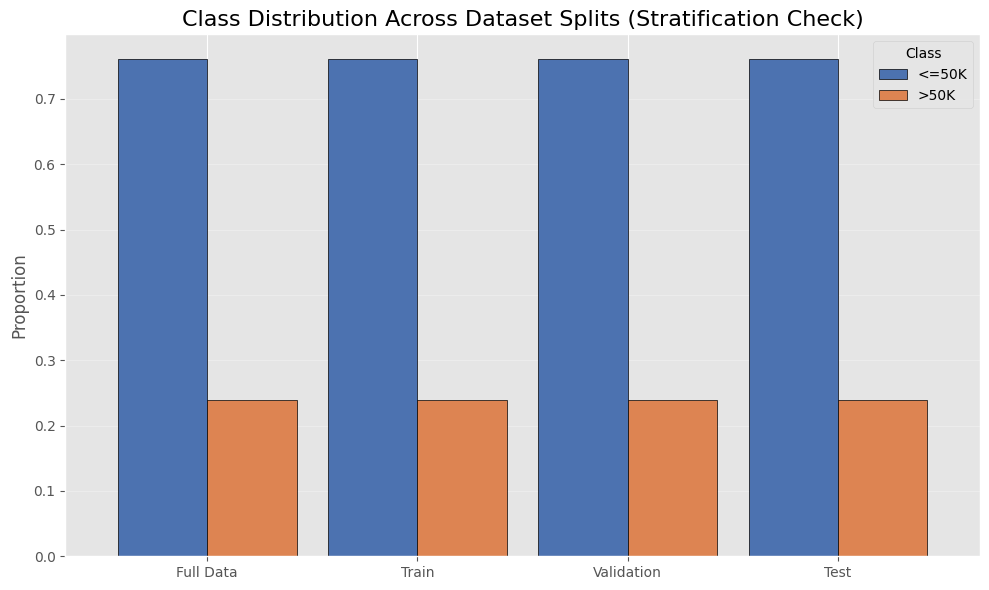

In [133]:
label_map = {0: '<=50K', 1: '>50K'}
datasets = {
    'Full Data': df_encoded['class'].map(label_map),
    'Train': train['class'].map(label_map),
    'Validation': val['class'].map(label_map),
    'Test': test['class'].map(label_map)
}
classes = ['<=50K', '>50K']
dist_data = pd.DataFrame({
    name: series.value_counts(normalize=True).reindex(classes, fill_value=0)
    for name, series in datasets.items()
}).T
fig, ax = plt.subplots(figsize=(10, 6))
dist_data.plot(kind='bar', ax=ax, edgecolor='black', width=0.85)
ax.set_title("Class Distribution Across Dataset Splits (Stratification Check)", fontsize=16)
ax.set_ylabel("Proportion")
ax.set_xticklabels(dist_data.index, rotation=0)
ax.grid(axis='y', alpha=0.3)
ax.legend(title="Class")
plt.tight_layout()
plt.show()


## 7. Manual Naïve Bayes Implementation (From Scratch)

In [134]:
class ManualCategoricalNB:
    def __init__(self, alpha=1.0):
        self.alpha=float(alpha)
    def fit(self,X,y):
        self.classes_=np.unique(y)
        n=len(y)
        K=len(self.classes_)
        self.priors_={c:(np.sum(y==c)+self.alpha)/(n+self.alpha*K) for c in self.classes_}
        D=X.shape[1]
        self.feature_values_={}
        self.likelihoods_=[{} for _ in range(D)]
        for j in range(D):
            vals=np.unique(X[:,j])
            self.feature_values_[j]=vals
            for c in self.classes_:
                Xc=X[y==c,j]
                n_c=len(Xc)
                V=len(vals)
                self.likelihoods_[j][c]={v:(np.sum(Xc==v)+self.alpha)/(n_c+self.alpha*V) for v in vals}
        return self
    def predict_proba(self,X):
        n=X.shape[0]
        K=len(self.classes_)
        logp=np.zeros((n,K))
        for idx,c in enumerate(self.classes_):
            logp[:,idx]=np.log(self.priors_[c])
            for j in range(X.shape[1]):
                probs=np.zeros(n)
                for i in range(n):
                    v=X[i,j]
                    if v in self.likelihoods_[j][c]:
                        probs[i]=self.likelihoods_[j][c][v]
                    else:
                        V=len(self.feature_values_[j])
                        n_c=np.sum(y_train==c)
                        probs[i]=self.alpha/(n_c+self.alpha*(V+1))
                logp[:,idx]+=np.log(probs)
        probs=np.exp(logp-logp.max(axis=1,keepdims=True))
        return probs/ probs.sum(axis=1,keepdims=True)
    def predict(self,X):
        return self.classes_[np.argmax(self.predict_proba(X),axis=1)]
    def evaluate_alphas(self,alphas,Xtr,ytr,Xv,yv):
        results={}
        for a in alphas:
            self.alpha=a
            self.fit(Xtr,ytr)
            pred=self.predict(Xv)
            results[a]=accuracy_score(yv,pred)
        return results

## 8. Train and Evaluate Base Model (α=1.0)

In [135]:
nb=ManualCategoricalNB(alpha=1.0)
nb.fit(X_train,y_train)
val_pred=nb.predict(X_val)
test_pred=nb.predict(X_test)
accuracy_score(y_val,val_pred), accuracy_score(y_test,test_pred)

(0.795932295932296, 0.7898184795960147)

## 9. Probability Analysis

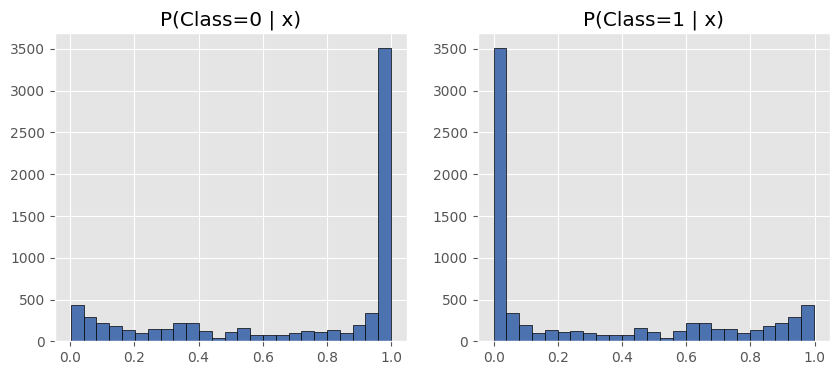

In [136]:
probs=nb.predict_proba(X_val)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(probs[:,0],bins=25,edgecolor='k')
plt.title('P(Class=0 | x)')
plt.subplot(1,2,2)
plt.hist(probs[:,1],bins=25,edgecolor='k')
plt.title('P(Class=1 | x)')
plt.show()

## 10. α Smoothing Test

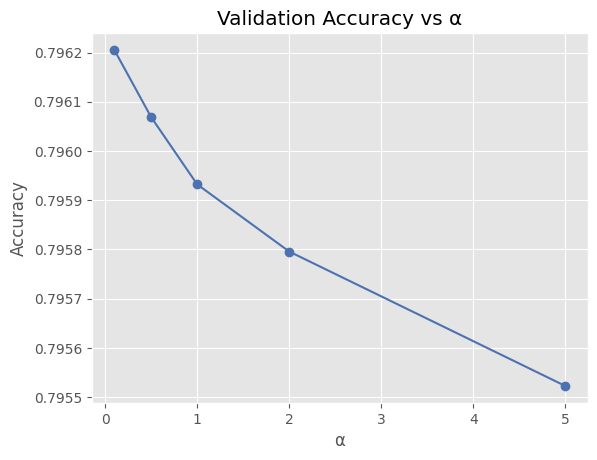

In [137]:
alphas=[0.1,0.5,1.0,2.0,5.0]
results=nb.evaluate_alphas(alphas,X_train,y_train,X_val,y_val)
results
plt.plot(list(results.keys()),list(results.values()),marker='o')
plt.title('Validation Accuracy vs α')
plt.xlabel('α')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## 11. Feature Subset Analysis

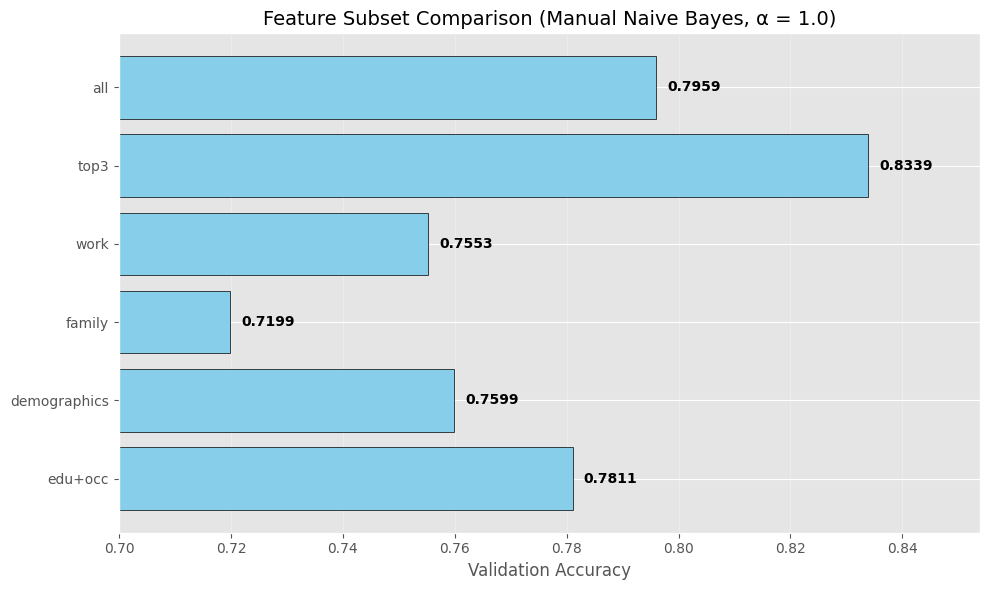

In [138]:
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]
feature_sets = {
    'edu+occ': ['education', 'occupation'],
    'demographics': ['race', 'sex', 'native-country'],
    'family': ['marital-status', 'relationship'],
    'work': ['workclass', 'occupation'],
    'top3': ['education', 'occupation', 'marital-status'],
    'all': categorical_cols
}
scores = {}
for name, cols in feature_sets.items():
    Xtr = train[cols].values
    Xv = val[cols].values
    m = ManualCategoricalNB(alpha=1.0)
    m.fit(Xtr, y_train)
    pred = m.predict(Xv)
    scores[name] = accuracy_score(y_val, pred)
scores

###3plotting :: 
plt.figure(figsize=(10, 6))
names = list(scores.keys())
vals = list(scores.values())
bars = plt.barh(names, vals, color='skyblue', edgecolor='black')
for i, v in enumerate(vals):
    plt.text(v + 0.002, i, f"{v:.4f}", va='center', fontweight='bold')
plt.xlabel("Validation Accuracy", fontsize=12)
plt.title("Feature Subset Comparison (Manual Naive Bayes, α = 1.0)", fontsize=14)
plt.xlim(min(vals) - 0.02, max(vals) + 0.02)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 12. sklearn Comparison

In [139]:
sk=CategoricalNB(alpha=1.0)
sk.fit(X_train,y_train)
sk_pred=sk.predict(X_val)
accuracy_score(y_val,val_pred), accuracy_score(y_val,sk_pred)

(0.795932295932296, 0.795932295932296)

## 13. Confusion Matrix

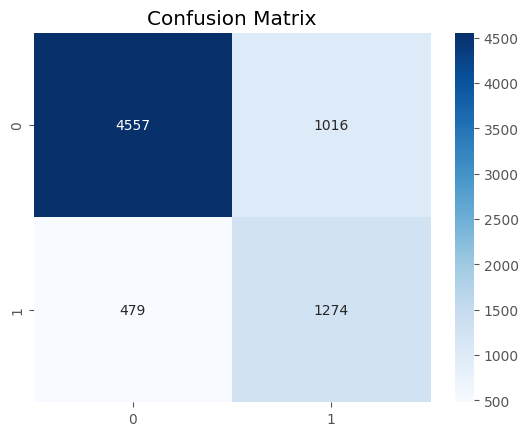

In [140]:
cm=confusion_matrix(y_val,val_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 14. Independence Assumption Discussion

Naïve Bayes assumes all features are conditionally independent given the class.  
However, in the Adult dataset, this is false:

- education with occupation 
- marital-status with  relationship 
- workclass with occupation

**Impact:**
- Probability estimates become less calibrated  
- But classification accuracy remains strong  
- Because dependency errors often cancel out in the argmax decision rule  
This explains why Naïve Bayes performs surprisingly well despite violated assumptions.


# Part C:

In [89]:
## Imports
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import time

### C.1 Helper funtions

#### C.1.1 Entropy, Gain and Split functions

In [90]:
# Entropy func
def entropyB(target_set:np.ndarray)->float:
    N = target_set.size
    if N == 0:
        raise ArithmeticError("cannot calculate entropy of empty set (N==0)")

    p = (target_set == 0).sum() #[t,f,t,f].sum()==2
    p = p/N
    p_ = 1-p

    H = -(p*np.log2(p + 10e-7) + p_*np.log2(p_ + 10e-7))
    
    return H,N #entropy and size of target_set

In [91]:
#Gain func
def gainB(target_set:np.ndarray, target_setL:np.ndarray, target_setR:np.ndarray) -> float:
    #H = entropy before split
    #HL = entropy of left
    #HR = entropy of right
    #gain = H - NL/N * HL - NR/N * HR

    H,N = entropyB(target_set)
    HL,NL = entropyB(target_setL)
    HR,NR = entropyB(target_setR)

    gain = H - (NL/N)*HL - (NR/N)*HR
    return gain


In [92]:
#splitting func
def split(feature_set:np.ndarray, target_set:np.ndarray, split): # returns data and target_setL and R
    if target_set.size == 0 or len(split) != 2:
        raise ArithmeticError("Invalid argument for split function(either target_set ==0 or split.size != 2)")
    
    feature = split[0]; threshold = split[1]

    condition_left = feature_set[:,feature] >= threshold
    condition_right = np.logical_not(condition_left)

    feature_setL = feature_set[condition_left]
    feature_setR = feature_set[condition_right]

    target_setL = target_set[condition_left]
    target_setR = target_set[condition_right]

    return feature_setL, target_setL, feature_setR, target_setR
    

In [93]:
#Tree class
class tree:
    def __init__(self,value):
        self.value = value
        self.left = None
        self.right = None

    def insert(self,value):
        if value >= self.value: # left
            self.left = tree(value)

        else:
            self.right = tree(value)

    def DesicionTraverse(self,sample):
        if self.left is None and self.right is None:
            return self.value[1]
        
        if sample[self.value[0]] >= self.value[1]: # left
            return self.left.DesicionTraverse(sample)
        else:
            return self.right.DesicionTraverse(sample)
        
    def DFT(self):
        if self.left is None:
            if self.right is None:
                slf =  self.value
                return slf
            
            slf = self.value
            rht = self.right.DFT()
            return slf,rht
        
        lft = self.left.DFT()
        slf = self.value

        if self.right is None:
            return lft,slf
        
        rht = self.right.DFT()
        return lft,slf,rht

        

### C.2 Loading and setting up data

In [94]:
#Downloading breast cancer data
dataMap = sklearn.datasets.load_breast_cancer()

features = dataMap.data
target = dataMap.target

#0 for malignent and 1 for benign
target_map = dataMap.target_names
features_map = dataMap.feature_names


In [95]:
print(dataMap.DESCR)

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [96]:
# split data into train, validation and split 70,15,15
feature_setTrain, feature_setT, target_setTrain, target_setT = train_test_split(
    
    features,target,
    train_size=0.70,
    test_size=0.30,
    stratify=target,
    random_state=42
)

feature_setVal, feature_setTest, target_setVal, target_setTest = train_test_split(
    
    feature_setT,target_setT,
    train_size=0.50,
    stratify=target_setT,
    random_state=42
)


### C.3 Setting up the tree

#### C.3.1 getting thresholds from training data

In [97]:
#Stopping criteria
MAX_DEPTH = 10
MIN_SAMP = 10

In [98]:
#getting thresholds
Thresholds = [] #(feature,threshold,idx)

In [99]:
#getting thresholds contin.
def set_Thresholds(feature_set:np.ndarray, target_set:np.ndarray, idx=0, depth=0):
    #base casses
    if  depth >= MAX_DEPTH:
        val = np.argmax(np.bincount(target_set))
        Thresholds.append([-1,val,idx]) #-1 means leaf or output
        return None

    if feature_set.shape[0] <= MIN_SAMP:
        val = np.argmax(np.bincount(target_set))
        Thresholds.append([-1,val,idx])
        return None
    
    H,_ = entropyB(target_set)
    if H <= 0.003:
        val = np.argmax(np.bincount(target_set))
        Thresholds.append([-1,val,idx])
        return None
    
    gainAllAtrMax = [0,-np.inf,0] #feature, gain, thresh 
    for attridx in range(feature_set.shape[1]):
        attr = feature_set[:,attridx]
        attr = np.sort(attr)

        gainAtrMax = [-np.inf,0] #gain, thresh
        for i in range(1,attr.size):
            mid = (attr[i-1] + attr[i])/2

            _, target_setL, _, target_setR = split(feature_set,target_set,[attridx,mid])
            if target_setL.size == 0 or target_setR.size == 0:
                continue

            g = gainB(target_set,target_setL,target_setR)

            if gainAtrMax[0] <= g:
                gainAtrMax[0] = g
                gainAtrMax[1] = mid

        if gainAllAtrMax[1] <= gainAtrMax[0]:
            gainAllAtrMax[0] = attridx
            gainAllAtrMax[1] = gainAtrMax[0]
            gainAllAtrMax[2] = gainAtrMax[1]

    
    fet = gainAllAtrMax[0]
    thresh = gainAllAtrMax[2]
    Thresholds.append([fet,thresh,idx])

    feature_setL, target_setL, feature_setR, target_setR = split(feature_set,target_set,(fet,thresh))
    set_Thresholds(feature_setL, target_setL, 2*idx+1, depth+1)
    set_Thresholds(feature_setR, target_setR, 2*idx+2, depth+1)
    return None
    


#### C.3.2 setting up TREE from threshold array

In [100]:
#threshold -> tree
def setTree():
    return sorted(Thresholds, key=lambda k : k[2])
    

#### C.3.3 Compined code for setting tree into class

In [101]:
class Dtree:
    def __init__(self):
        self.Thresholds = []
        self.DTREE = tree(0) #(feature,threshold,idx)
        self.MAX_DEPTH = 10
        self.MIN_SAMP = 10

    def stop_criteria(self,maxDepth=10,minSamp=10):
        self.MAX_DEPTH = maxDepth
        self.MIN_SAMP = minSamp

    def setData(self,feature_set,target_set):
        self.feature_set = feature_set
        self.target_set = target_set

    def Train(self):
        self.set_Thresholds(self.feature_set,self.target_set) 

    def Traverse(self,data:np.ndarray)->int:#traverse 1 data sample
        res = self.DTREE.DesicionTraverse(data)
        return res

    def Test(self,feature_set,target_set): #pred miscla
        pred =[]
        for i in range(feature_set.shape[0]):
            pred.append(self.Traverse(feature_set[i]))

        pred = np.array(pred)

        miscla = (pred == target_set) #[t,f,t,...]
        miscla = np.bincount(miscla) #[nf,nt] always 2 cols here
        miscla = miscla[1]/(miscla.sum()) #nt/nt+nf

        return pred,miscla

        

    #getting thresholds
    def set_Thresholds(self,feature_set:np.ndarray, target_set:np.ndarray, idx=0, depth=0):
        #base casses
        if  depth >= self.MAX_DEPTH:
            bin = np.bincount(target_set,minlength=2)
            val = np.argmax(bin)
            self.Thresholds.append([-1,val,idx]) #-1 means leaf or output
            return tree([-1,val])

        if feature_set.shape[0] <= self.MIN_SAMP:
            bin = np.bincount(target_set)
            val = np.argmax(bin)
            self.Thresholds.append([-1,val,idx])
            return tree([-1,val])
        
        H,_ = entropyB(target_set)
        if H <= 0.003:
            bin = np.bincount(target_set)
            val = np.argmax(bin)
            self.Thresholds.append([-1,val,idx])
            return tree([-1,val])

        gainAllAtrMax = [0,-np.inf,0] #feature, gain, thresh 
        for attridx in range(feature_set.shape[1]):
            attr = feature_set[:,attridx]
            attr = np.sort(attr)

            gainAtrMax = [-np.inf,0] #gain, thresh
            for i in range(1,attr.size):
                mid = (attr[i-1] + attr[i])/2

                _, target_setL, _, target_setR = split(feature_set,target_set,[attridx,mid])
                if target_setL.size == 0 or target_setR.size == 0:
                    continue

                g = gainB(target_set,target_setL,target_setR)

                if gainAtrMax[0] <= g:
                    gainAtrMax[0] = g
                    gainAtrMax[1] = mid

            if gainAllAtrMax[1] <= gainAtrMax[0]:
                gainAllAtrMax[0] = attridx
                gainAllAtrMax[1] = gainAtrMax[0]
                gainAllAtrMax[2] = gainAtrMax[1]

        
        fet = gainAllAtrMax[0]
        thresh = gainAllAtrMax[2]
        
        if idx == 0:
            self.DTREE = tree([fet,thresh])
            TREE = self.DTREE
        else:
            TREE = tree([fet,thresh])

        self.Thresholds.append([fet,thresh,idx])

        feature_setL, target_setL, feature_setR, target_setR = split(feature_set,target_set,(fet,thresh))
        Left = self.set_Thresholds(feature_setL, target_setL, 2*idx+1, depth+1)
        Right = self.set_Thresholds(feature_setR, target_setR, 2*idx+2, depth+1)
        TREE.left = Left
        TREE.right = Right
        return TREE
    


### C.4 anylisis

Done training model maxdep,minsample = (2, 2) and misclarate = 0.91765  confusion_matrix = [[32  0]] , [[ 7 46]]	 acc = 0.91765 prec = 1.00000 recal = 0.86792 f1 = 0.92929 test time = 0.00012
Done training model maxdep,minsample = (2, 5) and misclarate = 0.91765  confusion_matrix = [[32  0]] , [[ 7 46]]	 acc = 0.91765 prec = 1.00000 recal = 0.86792 f1 = 0.92929 test time = 0.00014
Done training model maxdep,minsample = (2, 10) and misclarate = 0.91765  confusion_matrix = [[32  0]] , [[ 7 46]]	 acc = 0.91765 prec = 1.00000 recal = 0.86792 f1 = 0.92929 test time = 0.00010
Done training model maxdep,minsample = (4, 2) and misclarate = 0.98824  confusion_matrix = [[32  0]] , [[ 1 52]]	 acc = 0.98824 prec = 1.00000 recal = 0.98113 f1 = 0.99048 test time = 0.00028
Done training model maxdep,minsample = (4, 5) and misclarate = 0.98824  confusion_matrix = [[32  0]] , [[ 1 52]]	 acc = 0.98824 prec = 1.00000 recal = 0.98113 f1 = 0.99048 test time = 0.00014
Done training model maxdep,minsample = 

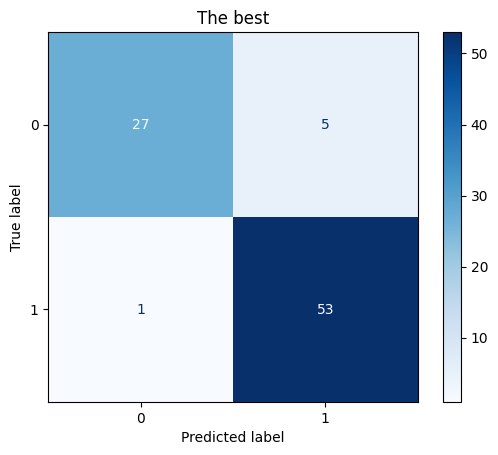

In [102]:
declass = Dtree()
declass.setData(feature_setTrain,target_setTrain)

anyls = [] #maxd,minsamp,misc
best_tree = None; bestmis = -np.inf
maxd = [2,4,6,8,10]; minSamp = [2,5,10]
for mx in maxd:
    for mns in minSamp:
        declass.stop_criteria(maxDepth=mx,minSamp=mns)
        declass.Train()
        startTime = time.perf_counter()
        _,mis = declass.Test(feature_setVal,target_setVal)
        endTime = time.perf_counter()
        elapsed = endTime - startTime
        if bestmis <= mis:
            bestmis = mis
            best_tree = declass.DTREE

        anyls.append([mx,mns,mis])
        cm = confusion_matrix(target_setVal,_)
        acc = (cm[0,0]+cm[1,1])/cm.sum()
        prec = (cm[1,1])/(cm[0,1]+cm[1,1])
        recal = cm[1,1]/(cm[1,0]+cm[1,1])
        f1 = 2*(recal*prec/(recal+prec))

        print(f"Done training model maxdep,minsample = {mx,mns} and misclarate = {mis:.5f}",end="")
        print(" ",f"confusion_matrix = [{cm[0]}] , [{cm[1]}]",end="")
        print("\t",f"acc = {acc:.5f} prec = {prec:.5f} recal = {recal:.5f} f1 = {f1:.5f} test time = {elapsed:.5f}")

anyls = np.array(anyls)
declass.DTREE = best_tree
pred,mis = declass.Test(feature_setTest,target_setTest)
print("\n--------------the best--------------")
print("\npredicted by model =\n" ,pred)
print("\nactual = \n",target_setTest)
print("\nmisclasification rate = ",mis,end="")

cm = confusion_matrix(target_setTest,pred)
acc = (cm[0,0]+cm[1,1])/cm.sum()
prec = (cm[1,1])/(cm[0,1]+cm[1,1])
recal = cm[1,1]/(cm[1,0]+cm[1,1])
f1 = 2*(recal*prec/(recal+prec))

print("\t",f"acc = {acc:.5f} prec = {prec:.5f} recal = {recal:.5f} f1 = {f1:.5f}")

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("The best")
plt.show()

[[ 2.          2.          0.91764706]
 [ 2.          5.          0.91764706]
 [ 2.         10.          0.91764706]
 [ 4.          2.          0.98823529]
 [ 4.          5.          0.98823529]
 [ 4.         10.          0.98823529]
 [ 6.          2.          0.96470588]
 [ 6.          5.          0.96470588]
 [ 6.         10.          0.96470588]
 [ 8.          2.          0.97647059]
 [ 8.          5.          0.96470588]
 [ 8.         10.          0.96470588]
 [10.          2.          0.97647059]
 [10.          5.          0.96470588]
 [10.         10.          0.96470588]]


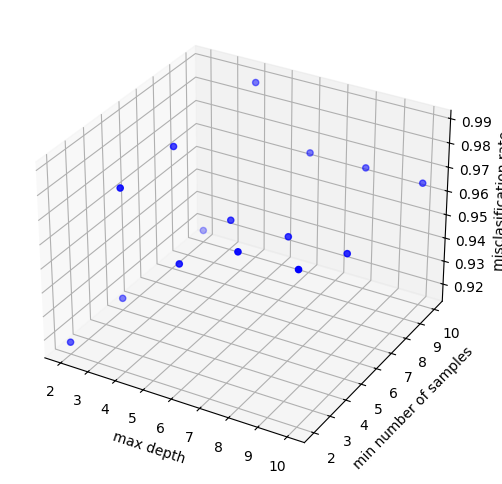

In [103]:
# Create 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
print(anyls)
ax.scatter(anyls[:, 0], anyls[:, 1], anyls[:, 2], c='blue', marker='o')
ax.set_xlabel("max depth")
ax.set_ylabel("min number of samples")
ax.set_zlabel("misclasification rate")
plt.show()


# Part D: Random Forest


In [104]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import time
from collections import Counter

In [105]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=10,
                 max_features='sqrt', random_state=None):

        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feature_subsets = []

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape

        # Determine number of features for each tree
        if self.max_features == 'sqrt':
            max_feat = int(np.sqrt(n_features))
        elif self.max_features == 'half':
            max_feat = n_features // 2
        else:
            max_feat = int(self.max_features)
        
        self.trees = []
        self.feature_subsets = [] # Keep this to track which features were used

        for _ in range(self.n_trees):
            indices = rng.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]

            # 1. Select the random subset of feature indices (0-29 for your data)
            feat_idx = rng.choice(n_features, size=max_feat, replace=False)
            self.feature_subsets.append(feat_idx)

            # 2. Get the feature data for this subset
            X_sub = X_boot[:, feat_idx]

            # 3. Train Dtree on this subset.
            # Dtree will now only see max_feat columns (features 0 to max_feat-1)
            # The tree index it learns will correspond to the index in X_sub.
            tree = Dtree()
            tree.stop_criteria(maxDepth=self.max_depth, minSamp=self.min_samples_split)
            tree.setData(X_sub, y_boot) # <--- Training on the subset
            tree.Train()

            self.trees.append(tree)

    def predict(self, X):
        n_samples = X.shape[0]
        tree_preds = []

        # Iterate through the trees and their corresponding feature indices
        for tree, feat_idx in zip(self.trees, self.feature_subsets):
            
            # Subsetting the test/validation data (X) for *this specific tree*
            X_sub = X[:, feat_idx]
            
            # The tree (Dtree) was trained on X_sub, so we must test it on X_sub
            preds = np.array([tree.Traverse(sample) for sample in X_sub])
            tree_preds.append(preds)

        tree_preds = np.array(tree_preds).T

        final_preds = np.array([
            Counter(row).most_common(1)[0][0]
            for row in tree_preds
        ])

        return final_preds

    def score(self, X, y):
        preds = self.predict(X)
        return (preds == y).mean()

In [106]:
def Forest_hyperparameter_tuning(x_train, x_val, x_test, y_train, y_val, y_test, T_values = [5, 10, 30, 50]):
    n_features = x_train.shape[1]

    max_features_options = [
        "sqrt",
        "half"
    ]

    results = []
    best_acc = -1
    best_params = None
    best_model = None

    for T in T_values:
        for mf in max_features_options:

            print(f"Training RF: T={T}, max_features={mf}")

            rf = RandomForest(
                n_trees=T,
                max_depth=MAX_DEPTH,
                min_samples_split=MIN_SAMP,
                max_features=mf,
                random_state=42
            )

            # Train on train only
            rf.fit(x_train, y_train)

            # Validate
            val_pred = rf.predict(x_val)
            val_acc = accuracy_score(y_val, val_pred)

            print(f"→ Validation accuracy: {val_acc:.4f}\n")

            results.append((T, mf, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_params = (T, mf)
                best_model = rf


    print("\n===== Hyperparameter Results =====")
    for T, mf, acc in results:
        print(f"T={T}, max_features={mf}, val_acc={acc:.4f}")

    print("\n===== BEST PARAMETERS FOUND =====")
    print(f"T = {best_params[0]}")
    print(f"max_features = {best_params[1]}")
    print(f"Validation Accuracy = {best_acc:.4f}")


    print("\nRetraining best model on TRAIN + VALIDATION...")

    X_train_full = np.vstack([x_train, x_val])
    y_train_full = np.hstack([y_train, y_val])

    rf_final = RandomForest(
        n_trees=best_params[0],
        max_depth=MAX_DEPTH,
        min_samples_split=MIN_SAMP,
        max_features=best_params[1],
        random_state=42
    )

    rf_final.fit(X_train_full, y_train_full)


    test_pred = rf_final.predict(x_test) #final model evaluation
    test_acc = accuracy_score(y_test, test_pred)

    print("\n===== FINAL TEST SET ACCURACY =====")
    print(f"Test Accuracy = {test_acc:.4f}")

    return {
        "best_model": rf_final,
        "best_params": best_params,
        "validation_results": results,
        "test_accuracy": test_acc
    }
    

In [107]:
def main():
    # Load dataset
    data = sklearn.datasets.load_breast_cancer()
    X, y = data.data, data.target
    
    x_train, x_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print("Dataset shapes:")
    print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

    # 3. Perform hyperparameter tuning
    results = Forest_hyperparameter_tuning(
        x_train, x_val, x_test,
        y_train, y_val, y_test,
        T_values=[5, 10, 30, 50]
    )

    # 4. Print summary
    print("\n===== FINAL SUMMARY =====")
    print("Best Parameters:", results["best_params"])
    print("Final Test Accuracy:", results["test_accuracy"])

    # 5. Confusion matrix for the returned best model
    best_model = results["best_model"]

    test_pred = best_model.predict(x_test)
    cm = confusion_matrix(y_test, test_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Random Forest Confusion Matrix (Best Tuned Model)")
    plt.show()

Dataset shapes:
Train: (398, 30) Val: (85, 30) Test: (86, 30)
Training RF: T=5, max_features=sqrt
→ Validation accuracy: 0.9294

Training RF: T=5, max_features=half
→ Validation accuracy: 0.9412

Training RF: T=10, max_features=sqrt
→ Validation accuracy: 0.9765

Training RF: T=10, max_features=half
→ Validation accuracy: 0.9882

Training RF: T=30, max_features=sqrt
→ Validation accuracy: 0.9765

Training RF: T=30, max_features=half
→ Validation accuracy: 0.9882

Training RF: T=50, max_features=sqrt
→ Validation accuracy: 0.9765

Training RF: T=50, max_features=half
→ Validation accuracy: 0.9882


===== Hyperparameter Results =====
T=5, max_features=sqrt, val_acc=0.9294
T=5, max_features=half, val_acc=0.9412
T=10, max_features=sqrt, val_acc=0.9765
T=10, max_features=half, val_acc=0.9882
T=30, max_features=sqrt, val_acc=0.9765
T=30, max_features=half, val_acc=0.9882
T=50, max_features=sqrt, val_acc=0.9765
T=50, max_features=half, val_acc=0.9882

===== BEST PARAMETERS FOUND =====
T = 10


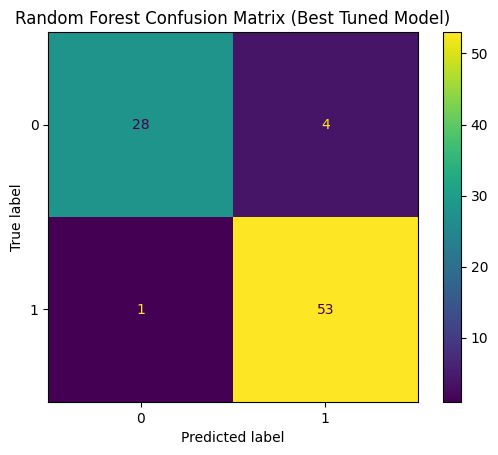

In [108]:
main()